In [12]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Optional, List, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
load_dotenv()  # take environment variables from .env file

True

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [15]:
class EvaluationSchema(BaseModel):
    score: int = Field(description="Score between 1 and 10")
    feedback: str = Field(description="Detailed feedback on the essay")

In [16]:
structured_model = model.with_structured_output(EvaluationSchema)

In [17]:
essay_text = """Technology has fundamentally transformed modern education, evolving from a supplementary tool to an essential core component of the learning environment. Its role is multifaceted, breaking down traditional barriers and creating dynamic, accessible, and personalized experiences for students.

Classrooms are no longer confined to physical spaces. Digital platforms, interactive whiteboards, and educational software make lessons more engaging, catering to diverse learning styles. More importantly, the internet provides unprecedented access to a vast repository of global knowledge and resources, democratizing education for learners everywhere.

Furthermore, technology enables personalized learning paths. Adaptive software can tailor lessons to a student’s individual pace and understanding, while data analytics help educators identify and address learning gaps promptly. From collaborative tools that connect students across the globe to immersive simulations that bring complex concepts to life, technology is not just changing how we teach, but enhancing how we learn, fostering a more inclusive and effective educational landscape for the 21st century."""

In [20]:
prompt = f"Evaluate the following UPSC essay on the topic 'Role of technology in modern education'. Provide a score between 1 and 10 and detailed feedback.\n\nEssay:\n{essay_text}"
structured_model.invoke(prompt).score

8

In [13]:
# defining state
class UPSCState(TypedDict):
    essay: str
    language_feedback: Optional[str]
    analysis_feedback: Optional[str]
    clarity_feedback: Optional[str]
    overall_feedback: Optional[str]
    individual_scores: Annotated[List[int], operator.add]  # to accumulate scores

In [21]:
# evaluate language function
def evaluate_language(state: UPSCState):
    
    prompt = f"Evaluate the language quality of the following essay. Provide a score between 1 and 10 and detailed feedback.\n\nEssay:\n{state['essay']}"
    result = structured_model.invoke(prompt)
    
    return {"language_feedback": result.feedback, "individual_scores": [result.score]}

In [22]:
def evaluate_analysis(state: UPSCState):
    
    prompt = f"Evaluate the analytical depth of the following essay. Provide a score between 1 and 10 and detailed feedback.\n\nEssay:\n{state['essay']}"
    result = structured_model.invoke(prompt)
    
    return {"analysis_feedback": result.feedback, "individual_scores": [result.score]}

In [23]:
def evaluate_clarity(state: UPSCState):
    
    prompt = f"Evaluate the clarity and coherence of the following essay. Provide a score between 1 and 10 and detailed feedback.\n\nEssay:\n{state['essay']}"
    result = structured_model.invoke(prompt)
    
    return {"clarity_feedback": result.feedback, "individual_scores": [result.score]}

In [24]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f"Based on the following feedbacks:\nLanguage Feedback: {state['language_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}\nClarity Feedback: {state['clarity_feedback']}\nProvide an overall evaluation summary for the essay."
    overall_feedback = model.invoke(prompt).content

    # calculating average score
    total_score = sum(state['individual_scores'])
    average_score = total_score / len(state['individual_scores'])
    
    return {"overall_feedback": overall_feedback, "average_score": average_score}

In [26]:
# defining graph
graph = StateGraph(UPSCState)

# adding nodes
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_clarity", evaluate_clarity)
graph.add_node("final_evaluation", final_evaluation)

# defining edges
graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_clarity")

graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_clarity", "final_evaluation")

graph.add_edge("final_evaluation", END)

# compiling graph
workflow = graph.compile()

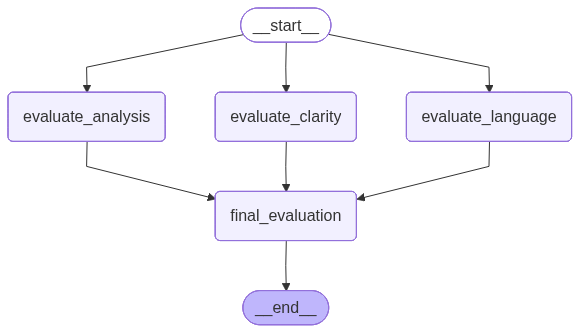

In [28]:
workflow

In [29]:
#initial state
initial_state = {
    "essay": essay_text,
    "language_feedback": None,
    "analysis_feedback": None,
    "clarity_feedback": None,
    "overall_feedback": None,
    "individual_scores": []
}

In [30]:
workflow.invoke(initial_state)

{'essay': 'Technology has fundamentally transformed modern education, evolving from a supplementary tool to an essential core component of the learning environment. Its role is multifaceted, breaking down traditional barriers and creating dynamic, accessible, and personalized experiences for students.\n\nClassrooms are no longer confined to physical spaces. Digital platforms, interactive whiteboards, and educational software make lessons more engaging, catering to diverse learning styles. More importantly, the internet provides unprecedented access to a vast repository of global knowledge and resources, democratizing education for learners everywhere.\n\nFurthermore, technology enables personalized learning paths. Adaptive software can tailor lessons to a student’s individual pace and understanding, while data analytics help educators identify and address learning gaps promptly. From collaborative tools that connect students across the globe to immersive simulations that bring complex 